In [1]:
import os
import yaml
import glob
import pathlib

import numpy as np
import pandas as pd

from math import ceil

from matplotlib import cm
import matplotlib.pyplot as plt

import zarr
import napari
import tifffile
import dask.array as da

from utils.utility_functions import (single_channel_pyramid, read_markers)

In [2]:
# Paths and inputs
sample = 'WD-76845-097'

cylinter_dir = '/Volumes/T7 Shield/cylinter_input/sardana-097/'
df = pd.read_parquet(os.path.join(cylinter_dir, 'output_raw/checkpoints/clustering.parquet'))

with open(os.path.join(cylinter_dir, 'config.yml')) as f:
    config = yaml.safe_load(f)
markers_to_exclude = config['channelExclusionsClustering']

markers, dna1, dna_moniker, abx_channels = read_markers(
    os.path.join(cylinter_dir, 'markers.csv'), markers_to_exclude, df
)

with open(os.path.join(cylinter_dir, 'output/contrast/contrast_limits.yml')) as f:
    contrast = yaml.safe_load(f)

out = os.path.join(os.getcwd(), 'output/2d_umap')
if not os.path.exists(out):
    os.makedirs(out)

In [3]:
# These gated cells will be assigned the dummy cluster label 100 
ids = pd.read_csv(
    os.path.join(os.getcwd(), 'input/gated_cell_IDs.csv'), index_col=0
).loc[:, '0'].tolist()

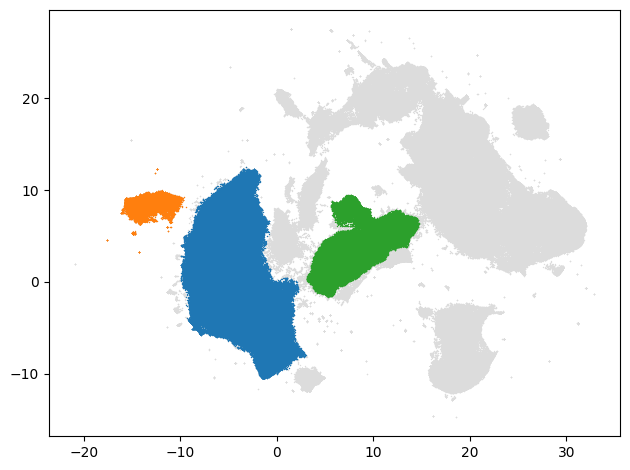

In [4]:
# Highlight clusters in 2D UMAP embedding
plt.scatter(df['emb1'], df['emb2'], s=1.0, lw=0.0, c='gainsboro')

plt.scatter(
    df['emb1'][(df['cluster_2d'] == 21) & (~df.index.isin(ids))],
    df['emb2'][(df['cluster_2d'] == 21) & (~df.index.isin(ids))],
    s=1.0, c='tab:green', lw=0.0, edgecolor=None
)
plt.scatter(
    df['emb1'][df.index.isin(ids)],
    df['emb2'][df.index.isin(ids)],
    s=1.0, c='tab:green', lw=0.0, edgecolor=None
)
plt.scatter(
    df['emb1'][df['cluster_2d'] == 1],
    df['emb2'][df['cluster_2d'] == 1],
    s=1.0, lw=0.0, c='tab:orange'
)
plt.scatter(
    df['emb1'][df['cluster_2d'] == 17],
    df['emb2'][df['cluster_2d'] == 17],
    s=1.0, lw=0.0, c='tab:blue'
)
plt.tight_layout()
plt.savefig(os.path.join(out, 'umap.png'), dpi=800)
plt.show()
plt.close('all')

In [5]:
# Show clusters in the CRC image
data = df[df['cluster_2d'].isin([1, 21, 17])].copy()
data.loc[data.index.isin(ids), 'cluster_2d'] = 100  # dummy cluster label

viewer = napari.Viewer()

sample_path = (
    pathlib.Path(glob.glob(os.path.join(cylinter_dir, f'tif/{sample}.*.tif'))[0]).resolve()
)
abx_channels.reverse()
for ch in abx_channels:
    channel_number = markers['channel_number'][markers['marker_name'] == ch]
    img, min, max = single_channel_pyramid(sample_path, channel=(channel_number.item() - 1))
    viewer.add_image(
        img, rgb=False, blending='additive', colormap='green', visible=False,
        name=ch, contrast_limits=(contrast[ch][0], contrast[ch][1])
    )

seg_path = pathlib.Path(glob.glob(os.path.join(cylinter_dir, f'seg/{sample}*.tif'))[0]).resolve()
seg, min, max = single_channel_pyramid(seg_path, channel=0)
viewer.add_image(
    seg, rgb=False, blending='additive', colormap='gray', visible=False,
    name='segmentation', opacity=0.3, contrast_limits=(min, max)
)

dna, min, max = single_channel_pyramid(sample_path, channel=0)
viewer.add_image(
    dna, rgb=False, blending='additive', colormap='gray', visible=True, opacity=1.0,
    name='DNA1', contrast_limits=(min, max)
)

num_colors = len(list(cm.tab10.colors))
num_clusters = len(data['cluster_2d'].unique())
palette_multiplier = ceil(num_clusters / num_colors)
colors = list(cm.tab10.colors) * palette_multiplier
colors = colors[0:num_clusters]

for c, pop in zip(colors, [17, 1, 21, 100]):
    centroids = data[['Y_centroid', 'X_centroid']][data['cluster_2d'] == pop]
    if pop == 17:
        c = np.array(colors[0])
    elif pop == 1:
        c = np.array(colors[1])
    elif pop == 21:
        c = np.array(colors[2])
    elif pop == 100:
        c = np.array(colors[2])
    viewer.add_points(
        centroids, name=pop, face_color=np.array(c), edge_color=np.array(c),
        edge_width=0.0, size=6.0, opacity=1.0, blending='translucent',
        visible=False
    )

viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()

KeyboardInterrupt: 